# 2-dimensional q-state Potts model
### Monte Carlo Methods - WS 23/24
hbarsquared

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,njit
import time

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5   # Major tick size in points
plt.rcParams['ytick.major.size'] = 5   # Major tick size in points
plt.rcParams['xtick.major.width'] = 1   # Major tick width in points
plt.rcParams['ytick.major.width'] = 1   # Major tick width in points
plt.rcParams['legend.fontsize'] = 14

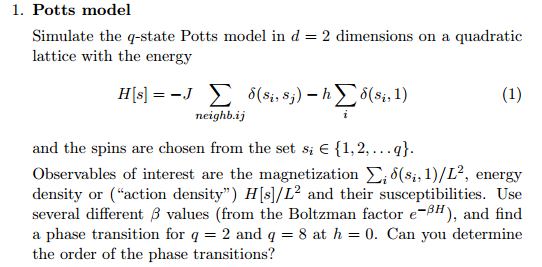

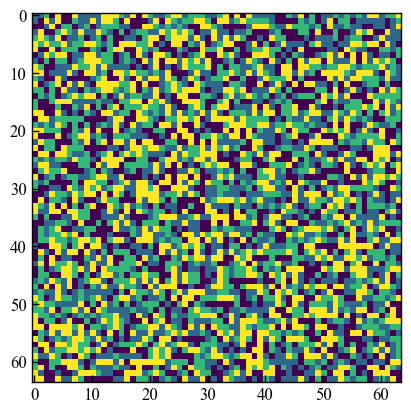

In [2]:
L = 64
q = 4
J = 1

mcsmax, no, n_delta = 5000,100,30  # Monte Carlo steps, initial cool-down steps, autocorrelation steps

beta = np.linspace(0,10,10)

spin_values = np.arange(0,q)+1 #+1 to get 1,2,3,4 instead of 0,1,2,3

def initial_lattice(L):
    return np.random.choice(spin_values, size=(L, L))

init_lattice= initial_lattice(L)
init_lattice


plt.figure()
plt.imshow(init_lattice)
#plt.legend()

## V0.1 - For one L value

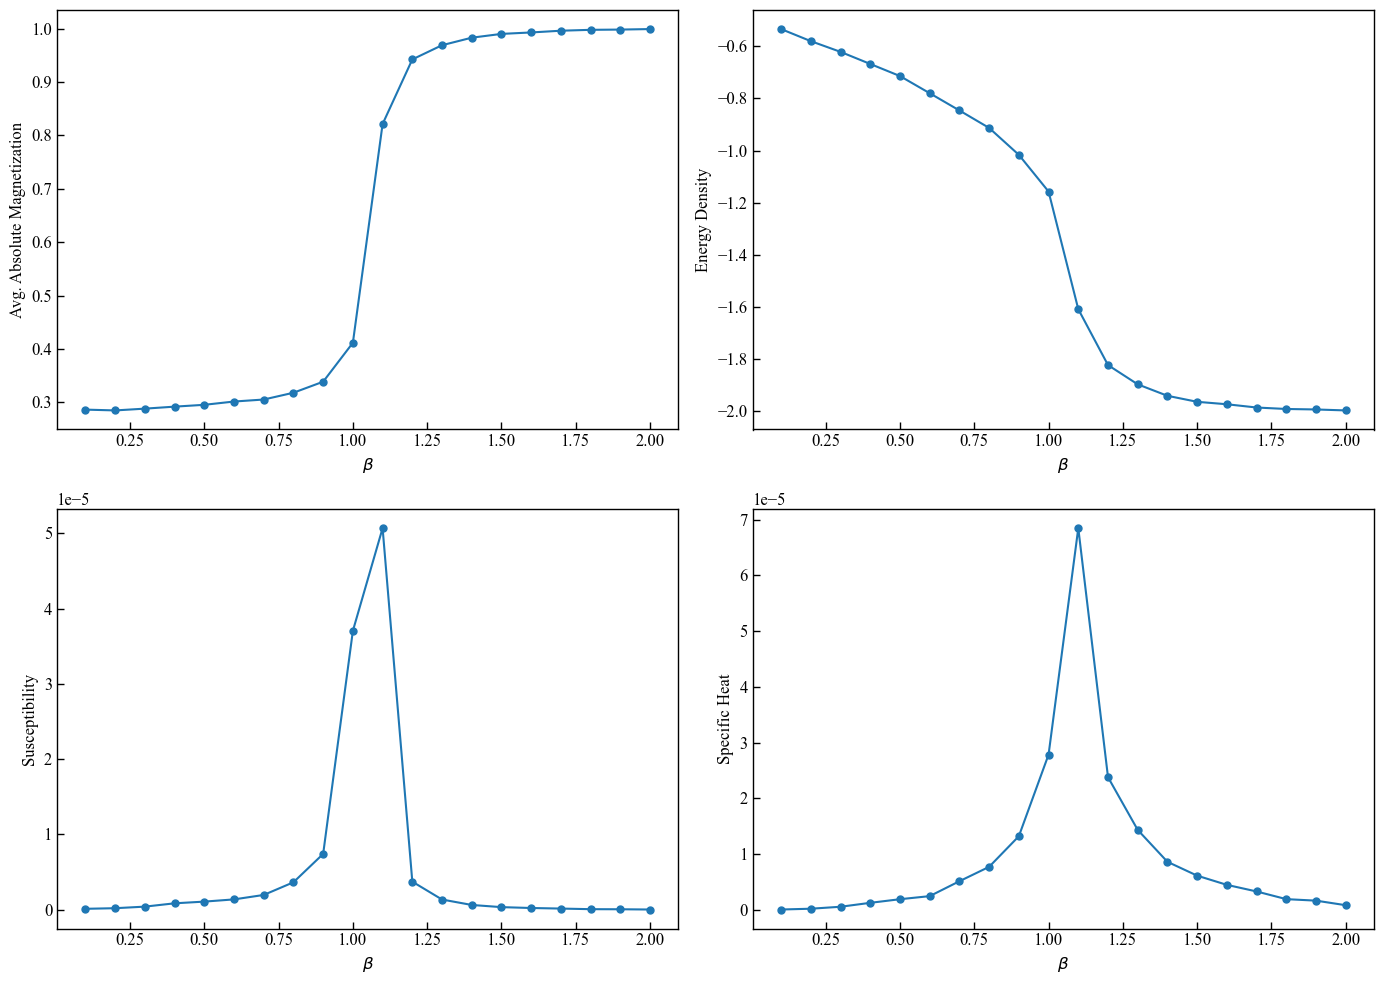

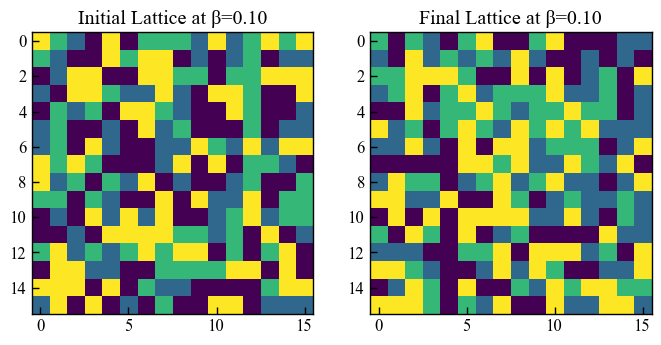

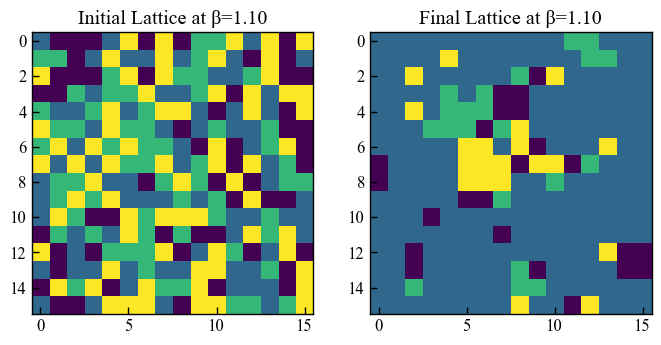

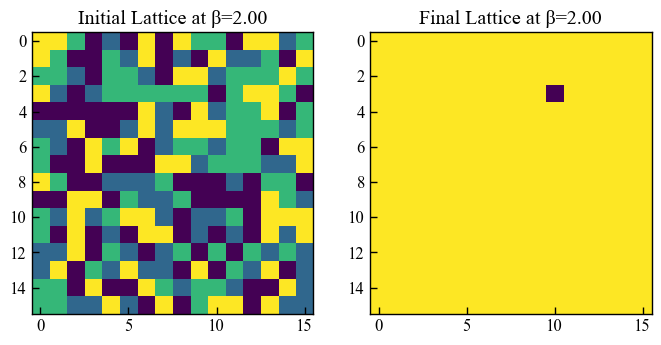

In [2]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

# Define simulation parameters
L = 16
q = 4
mcsmax = 5000
no = 800
n_delta = 30
beta_range = np.linspace(0.1, 2.0, 20)
spin_values = np.arange(1, q + 1)

@njit
def delta_energy(lattice, x, y, new_state, L):
    energy_diff = 0
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        neighbor_x, neighbor_y = (x + dx) % L, (y + dy) % L
        if lattice[neighbor_x, neighbor_y] == lattice[x, y]:
            energy_diff += 1
        if lattice[neighbor_x, neighbor_y] == new_state:
            energy_diff -= 1
    return energy_diff

@njit
def metropolis_step(lattice, beta, L, spin_values):
    for _ in range(L**2):
        x, y = np.random.randint(0, L, size=2)
        current_state = lattice[x, y]
        
        new_state_idx = np.random.randint(1, q)  # Choose an index to change state
        new_state = (current_state + new_state_idx) % q
        if new_state == 0:
            new_state = q

        dE = delta_energy(lattice, x, y, new_state, L)
        if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
            lattice[x, y] = new_state


@njit
def calculate_observables(lattice, L, q):
    state_counts = np.zeros(q)
    for i in range(q):
        state_counts[i] = np.sum(lattice == (i + 1))
    m_density = np.max(state_counts) / L**2  # Absolute magnetization
    e_density = 0
    for x in range(L):
        for y in range(L):
            current_state = lattice[x, y]
            for dx, dy in [(0, 1), (1, 0)]:
                if lattice[(x + dx) % L, (y + dy) % L] == current_state:
                    e_density -= 1
    e_density /= L**2
    return m_density, e_density


def simulate_potts(L, beta_range, mcsmax, no, n_delta, spin_values):
    mag_density_results = []
    energy_density_results = []
    susceptibility_results = []
    specific_heat_results = []
    lattice_states = {}  # To store initial and final lattice states for selected betas
    
    selected_betas = [beta_range[0], beta_range[len(beta_range) // 2], beta_range[-1]]  # Low, middle, high beta
    
    for beta in beta_range:
        lattice = np.random.choice(spin_values, size=(L, L))
        
        if beta in selected_betas:
            lattice_states[beta] = {'initial': lattice.copy()}  # Store initial state
        
        m_sum = m_square_sum = e_sum = e_square_sum = 0
        measurements = 0
        
        # Equilibration
        for _ in range(no):
            metropolis_step(lattice, beta, L, spin_values)
        
        # Measurement
        for _ in range(mcsmax // (1 + n_delta)):
            metropolis_step(lattice, beta, L, spin_values)
            m_density, e_density = calculate_observables(lattice, L, q)
            
            m_sum += m_density
            m_square_sum += m_density ** 2
            e_sum += e_density
            e_square_sum += e_density ** 2
            measurements += 1
            
            # n_delta steps
            for _ in range(n_delta):
                metropolis_step(lattice, beta, L, spin_values)
        
        m_avg = m_sum / measurements
        e_avg = e_sum / measurements
        m2_avg = m_square_sum / measurements
        e2_avg = e_square_sum / measurements
        N = L**2
        
        mag_density_results.append(m_avg)
        energy_density_results.append(e_avg)
        susceptibility_results.append(beta * (m2_avg - m_avg**2) / N)
        specific_heat_results.append((beta**2) * (e2_avg - e_avg**2) / N)
        
        if beta in selected_betas:
            lattice_states[beta]['final'] = lattice.copy()  # Store final state
    
    return beta_range, mag_density_results, energy_density_results, susceptibility_results, specific_heat_results, lattice_states

# Adjust the function call and plotting accordingly
beta_range, mag_density, energy_density, susceptibility, specific_heat, lattice_states = simulate_potts(L, beta_range, mcsmax, no, n_delta, spin_values)

# Extend the plotting section for susceptibility and specific heat
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(beta_range, mag_density, '-o')
plt.xlabel(r'$\beta$')
plt.ylabel('Avg. Absolute Magnetization')

plt.subplot(2, 2, 2)
plt.plot(beta_range, energy_density, '-o')
plt.xlabel(r'$\beta$')
plt.ylabel('Energy Density')

plt.subplot(2, 2, 3)
plt.plot(beta_range, susceptibility, '-o')
plt.xlabel(r'$\beta$')
plt.ylabel('Susceptibility')

plt.subplot(2, 2, 4)
plt.plot(beta_range, specific_heat, '-o')
plt.xlabel(r'$\beta$')
plt.ylabel('Specific Heat')

plt.tight_layout()
plt.show()

# Plotting lattice states for selected betas
for beta, states in lattice_states.items():
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(states['initial'], cmap='viridis')
    axs[0].set_title(f'Initial Lattice at β={beta:.2f}')
    axs[1].imshow(states['final'], cmap='viridis')
    axs[1].set_title(f'Final Lattice at β={beta:.2f}')
    plt.show()



But now to try and plot some cool stuff for the paper

In [36]:
# Ensure selected_betas includes the specific values you're interested in
selected_betas = [beta_range[0], beta_range[len(beta_range) // 2], beta_range[-1]]

# Proceed with simulation to populate lattice_states
beta_range, mag_density, energy_density, susceptibility, specific_heat, lattice_states = simulate_potts(L, beta_range, mcsmax, no, n_delta, spin_values)

# Define simulation parameters
L = 128
q = 4
mcsmax = 150000
no = 10000
n_delta = 500
beta_range = np.linspace(0.1, 2.0, 20)
spin_values = np.arange(1, q + 1)

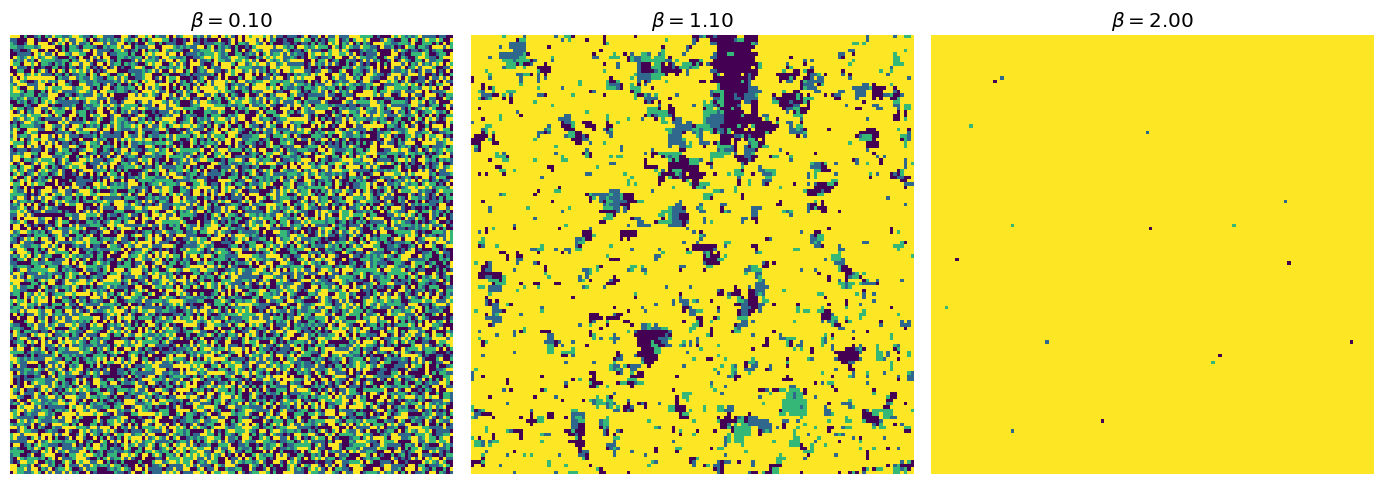

In [37]:

# Plotting final lattice states for selected betas in one figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(14, 5))  # Adjust figsize as needed

for i, beta in enumerate(selected_betas):
    axs[i].imshow(lattice_states[beta]['final'], cmap='viridis', aspect='auto')
    axs[i].set_title(f'$\\beta={beta:.2f}$')
    axs[i].axis('off')  # Optionally turn off axis for a cleaner look

plt.tight_layout()
plt.show()
fig.savefig('3pottssubplots_3.png')

In [ ]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

# Define simulation parameters
L = 16  # Lattice size
q = 4   # Number of states in the Potts model
mcsmax = 5000  # Number of Monte Carlo steps for measurement
no = 800  # Number of steps for equilibration
spin_values = np.arange(1, q + 1)  # Possible spin states

@njit
def delta_energy(lattice, x, y, new_state, L):
    """Calculate the energy difference resulting from a spin change."""
    energy_diff = 0
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        neighbor_x, neighbor_y = (x + dx) % L, (y + dy) % L
        if lattice[neighbor_x, neighbor_y] == lattice[x, y]:
            energy_diff += 1
        if lattice[neighbor_x, neighbor_y] == new_state:
            energy_diff -= 1
    return energy_diff

@njit
def metropolis_step(lattice, beta, L, spin_values, q):
    """Perform one Metropolis update on the lattice."""
    for _ in range(L**2):
        x, y = np.random.randint(0, L, size=2)
        current_state = lattice[x, y]
        new_state = np.random.choice(spin_values[spin_values != current_state])
        dE = delta_energy(lattice, x, y, new_state, L)
        if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
            lattice[x, y] = new_state

@njit
def calculate_observables(lattice, L, q):
    """Calculate observables like magnetization and energy density."""
    # Assuming q=2 for simplicity in magnetization calculation
    m_density = np.abs(np.sum(lattice) / L**2 - 0.5)  # Adjusted for demonstration
    return m_density

def simulate_magnetization_distribution(L, beta, mcsmax, no, spin_values, q):
    """Simulate and collect magnetization data for histogram."""
    lattice = np.random.choice(spin_values, size=(L, L))
    magnetization_data = []
    
    # Equilibration
    for _ in range(no):
        metropolis_step(lattice, beta, L, spin_values, q)
    
    # Measurement
    for _ in range(mcsmax):
        metropolis_step(lattice, beta, L, spin_values, q)
        m_density = calculate_observables(lattice, L, q)
        magnetization_data.append(m_density)
    
    return magnetization_data

# Choose a high beta value
high_beta = 1.5

# Run simulation to collect magnetization data
magnetization_data = simulate_magnetization_distribution(L, high_beta, mcsmax, no, spin_values, q)

# Plot the probability distribution of magnetization
plt.figure(figsize=(8, 6))
plt.hist(magnetization_data, bins=50, density=True, alpha=0.75, color='royalblue')
plt.xlabel('Magnetization Density')
plt.ylabel('Probability Density')
plt.title(f'Probability Distribution of Magnetization at $\\beta = {high_beta}$')
plt.grid(axis='y', alpha=0.75)
plt.show()


## V0.2 - For multiple L-values

## V0.3 - values stored before plotting

In [2]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
@njit
def delta_energy(lattice, x, y, new_state, L):
    energy_diff = 0
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        neighbor_x, neighbor_y = (x + dx) % L, (y + dy) % L
        if lattice[neighbor_x, neighbor_y] == lattice[x, y]:
            energy_diff += 1
        if lattice[neighbor_x, neighbor_y] == new_state:
            energy_diff -= 1
    return energy_diff

@njit
def metropolis_step(lattice, beta, L, q):
    for _ in range(L**2):
        x, y = np.random.randint(0, L, size=2)
        current_state = lattice[x, y]
        
        # Randomly pick a new state, excluding the current one
        new_state_idx = np.random.randint(1, q)  # Choose an index to change state
        new_state = (current_state + new_state_idx) % q
        if new_state == 0:
            new_state = q

        dE = delta_energy(lattice, x, y, new_state, L)
        if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
            lattice[x, y] = new_state

@njit
def calculate_observables(lattice, L, q):
    state_counts = np.zeros(q)
    for i in range(q):
        state_counts[i] = np.sum(lattice == (i + 1))
    m_density = np.max(state_counts) / L**2  # Absolute magnetization
    e_density = 0
    for x in range(L):
        for y in range(L):
            current_state = lattice[x, y]
            for dx, dy in [(0, 1), (1, 0)]:
                if lattice[(x + dx) % L, (y + dy) % L] == current_state:
                    e_density -= 1
    e_density /= L**2
    return m_density, e_density

def simulate_potts(L_values, beta_range, mcsmax, no, n_delta, q):
    results = {L: {'mag_density': [], 'energy_density': [], 'susceptibility': [], 'specific_heat': []} for L in L_values}
    
    for L in L_values:
        spin_values = np.arange(1, q + 1)
        mag_density, energy_density, susceptibility, specific_heat = [], [], [], []
        
        for beta in beta_range:
            lattice = np.random.choice(spin_values, size=(L, L))
            m_sum = 0
            m_square_sum = 0
            e_sum = 0
            e_square_sum = 0
            measurements = 0
            
            # Equilibration
            for _ in range(no):
                metropolis_step(lattice, beta, L, q)
            
            # Measurement
            for _ in range(mcsmax // (1 + n_delta)):
                metropolis_step(lattice, beta, L, q)
                m_density, e_density = calculate_observables(lattice, L, q)
                m_sum += m_density
                m_square_sum += m_density ** 2
                e_sum += e_density
                e_square_sum += e_density ** 2
                measurements += 1
                
                # Perform n_delta Metropolis steps without measurement
                for _ in range(n_delta):
                    metropolis_step(lattice, beta, L, q)
            
            # Store averages and susceptibilities/specific heats
            mag_density.append(m_sum / measurements)
            energy_density.append(e_sum / measurements)
            susceptibility.append(beta * (m_square_sum / measurements - (m_sum / measurements)**2) )#/ (L**2))
            specific_heat.append((beta**2) * (e_square_sum / measurements - (e_sum / measurements)**2))# / (L**2))
        
        # Save results for L
        results[L]['mag_density'] = mag_density
        results[L]['energy_density'] = energy_density
        results[L]['susceptibility'] = susceptibility
        results[L]['specific_heat'] = specific_heat
    
    return results

# Example usage



# Simulation parameters
mcsmax = 14
no = 4
n_delta = 1
#try like the one crappy paper mcsmax=no and n_delta small
beta_range = np.linspace(0.1, 2.0, 25)
L_values = [8,16, 32, 64]#,128]
q = 2

# Calculate the critical temperature for the given q
beta_c = np.log(1 + np.sqrt(q))

results = simulate_potts(L_values, beta_range, mcsmax, no, n_delta, q)


## revised version of computation

In [24]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

############################################################ Functions ####################################################
@njit
def delta_energy(lattice, x, y, new_state, L):
    energy_diff = 0
    neighbors = [((x - 1) % L, y), ((x + 1) % L, y), (x, (y - 1) % L), (x, (y + 1) % L)]
    current_state = lattice[x, y]
    for nx, ny in neighbors:
        if lattice[nx, ny] == current_state:
            energy_diff += 1
        if lattice[nx, ny] == new_state:
            energy_diff -= 1
    return energy_diff

#Perform one metropolis step
@njit
def metropolis_step(lattice, beta, L, q):
    for _ in range(L**2):
        x, y = np.random.randint(0, L, size=2)
        current_state = lattice[x, y]
        new_state = (current_state + np.random.randint(1, q)) % q
        if new_state == current_state:  # Just in case of modulo wrap that equals the current state
            new_state = (new_state + 1) % q

        dE = delta_energy(lattice, x, y, new_state, L)
        if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
            lattice[x, y] = new_state

@njit
def calculate_observables(lattice, L, q):
    state_counts = np.zeros(q)
    for i in range(q):
        state_counts[i] = np.sum(lattice == i)
    m_density = np.max(state_counts) / L**2  # Absolute magnetization
    e_density = 0
    for x in range(L):
        for y in range(L):
            current_state = lattice[x, y]
            neighbors = [(x, (y + 1) % L), ((x + 1) % L, y)]
            for nx, ny in neighbors:
                if lattice[nx, ny] == current_state:
                    e_density -= 1
    e_density /= L**2

    return m_density, e_density

def simulate_potts(L_values, beta_range, mcsmax, no, n_delta, q):
    results = {L: {'mag_density': [], 'energy_density': [], 'susceptibility': [], 'specific_heat': []} for L in L_values}
    total_steps = len(L_values) * len(T_range)
    step_counter = 0
    for L in L_values:
        start_L = time.time()
        for beta in beta_range:
            step_counter += 1
            lattice = np.random.randint(0, q, size=(L, L))
            m_sum = e_sum = m_square_sum = e_square_sum = 0
            measurements=0
            
            # Equilibration
            for _ in range(no):
                metropolis_step(lattice, beta, L, q)
            
            # Measurement
            for _ in range(mcsmax // (1 + n_delta)):
                metropolis_step(lattice, beta, L, q)
                m_density, e_density = calculate_observables(lattice, L, q)
                m_sum += m_density
                m_square_sum += m_density ** 2
                e_sum += e_density
                e_square_sum += e_density ** 2
                measurements += 1
                
                # n_delta Metropolis steps without measurement
                for _ in range(n_delta):
                    metropolis_step(lattice, beta, L, q)
            
            # Store results
            results[L]['mag_density'].append(m_sum / measurements)
            results[L]['energy_density'].append(e_sum / measurements)
            results[L]['susceptibility'].append(beta * (m_square_sum / measurements - (m_sum / measurements) ** 2))
            results[L]['specific_heat'].append((beta ** 2) * (e_square_sum / measurements - (e_sum / measurements) ** 2))
            print(f"Progress: {100 * step_counter / total_steps:.2f}% complete. L={L}, T={T:.2f}")
        
        end_L = time.time()
        print(f"Completed L={L} in {end_L - start_L:.2f} seconds.")

    return results
# Save the results to a CSV file

def save_results_to_csv(results, L_values, beta_range):
    # Flatten the results and prepare for DataFrame
    flat_results = {
        'Lattice Size': [],
        'Beta': [],
        'Magnetization Density': [],
        'Energy Density': [],
        'Susceptibility': [],
        'Specific Heat': []
    }

    for L in L_values:
        for i, beta in enumerate(beta_range):
            flat_results['Lattice Size'].append(L)
            flat_results['Beta'].append(beta)
            flat_results['Magnetization Density'].append(results[L]['mag_density'][i])
            flat_results['Energy Density'].append(results[L]['energy_density'][i])
            flat_results['Susceptibility'].append(results[L]['susceptibility'][i])
            flat_results['Specific Heat'].append(results[L]['specific_heat'][i])

    # Create DataFrame and save to CSV
    df = pd.DataFrame(flat_results)
    df.to_csv(f'pottsdata/pottsdata_q{q}_beta_L{L_values}_mcsmax{mcsmax}_no{no}_ndelta{n_delta}.csv', index=True)
    df.head()
    return df


# Example usage parameters
mcsmax = 400
no = 50
n_delta = 10
beta_range = np.linspace(0.2, 1.80, 30)
L_values = [8, 16, 32, 64]  # up to 64 for now
q = 2  # number of states

# Run simulation
# After running the simulation, save the results
start_time = time.time()
results = simulate_potts(L_values, beta_range, mcsmax, no, n_delta, q)
end_time = time.time()
print(f"Simulation run time: {end_time - start_time:.2f} seconds")
data = save_results_to_csv(results, L_values, beta_range)
data.head()

Simulation run time: 12.39 seconds


,Lattice Size,Beta,Magnetization Density,Energy Density,Susceptibility,Specific Heat
0,8,0.200000,0.570312,-1.112847,0.000595,0.000450
1,8,0.255172,0.567708,-1.111979,0.000609,0.000987
2,8,0.310345,0.582899,-1.172743,0.001144,0.000917
3,8,0.365517,0.578125,-1.214410,0.001096,0.001067
4,8,0.420690,0.586372,-1.217014,0.001703,0.001728


NameError: name 'beta_range' is not defined

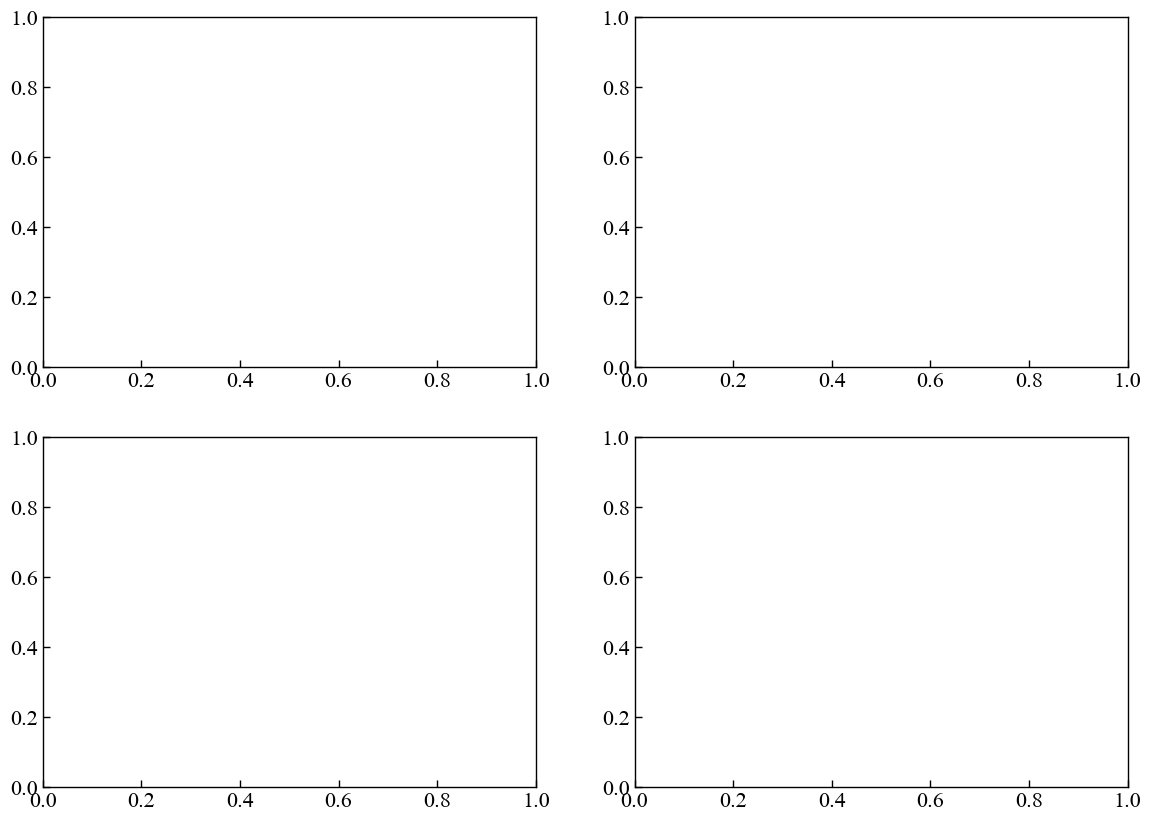

In [94]:
#results = pd.read_csv('pottsdata/pottsdata_q2_T_L[8, 16, 24, 32, 40, 50, 60]_mcsmax50000_no30000_ndelta10.csv')
######################################################## Plotting ################################################################
markers = ['o', 's', '^', 'D']  # Example: circle, square, triangle up, diamond
linestyles = ['-', '--', '-.', ':','--','--','--']  # Example: solid, dashed, dash-dot, dotted

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, L in enumerate(L_values):
    axs[0].plot(beta_range, results[L]['mag_density'], linestyle=linestyles[i],color='k', label=f'L={L}')
    axs[1].plot(beta_range, results[L]['energy_density'], linestyle=linestyles[i],color='k', label=f'L={L}')
    axs[2].plot(beta_range, results[L]['susceptibility'], linestyle=linestyles[i],color='k', label=f'L={L}')
    axs[3].plot(beta_range, results[L]['specific_heat'], linestyle=linestyles[i],color='k', label=f'L={L}')

for ax in axs:
    ax.axvline(x=beta_c, color='r', linestyle='--', linewidth=2, label=f' $\\beta_c$')

# Set titles, labels, and legends
titles = ['Avg. Absolute Magnetization', 'Energy Density', 'Susceptibility', 'Specific Heat']
y_labels = [r'$\langle \vert M \vert \rangle /L^2$', '$H/L^2$', '$\chi$', '$C_V$']

for ax, title, y_label in zip(axs, titles, y_labels):
    #ax.set_title(title)
    ax.set_xlabel(r'$\beta$')
    ax.set_xlim(0.2,1.5)
    ax.set_ylabel(y_label)
    ax.tick_params(direction='in', length=5, width=1, which='both')
    ax.legend()
    formatter = ScalarFormatter(useMathText=True)  # Use math text for prettier output
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))  # Use scientific notation if log10 of the axis range is smaller than -1 or larger than 1
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

plt.tight_layout()
plt.show()
fig.savefig(f"pottsdata/pottsobservables_q{q}_L{L_values}_mcsmax{mcsmax}_no{no}_ndelta{n_delta}.png")

# Temperature as parameter

In [99]:

import numpy as np
from numba import njit
import pandas as pd
import time

@njit
def delta_energy(lattice, x, y, new_state, L):
    #Calculating energy change for single spin flip
    energy_diff = 0
    neighbors = [((x - 1) % L, y), ((x + 1) % L, y), (x, (y - 1) % L), (x, (y + 1) % L)] #pbc taken into account
    current_state = lattice[x, y]
    for nx, ny in neighbors:
        if lattice[nx, ny] == current_state:
            energy_diff += 1
        if lattice[nx, ny] == new_state:
            energy_diff -= 1
    return energy_diff

from numba import njit, prange

@njit
def metropolis_step(lattice, T, L, q):
    # One Monte Carlo sweep - sequential update
    for x in range(L):
        for y in range(L):
            current_state = lattice[x, y]
            new_state = (current_state + np.random.randint(1, q)) % q
            dE = delta_energy(lattice, x, y, new_state, L)
            if dE <= 0 or np.random.rand() < np.exp(-dE / T): # Acceptance criteria
                lattice[x, y] = new_state



@njit
def calculate_observables(lattice, L, q):
    #Track and calculate energy and magnetization
    state_counts = np.zeros(q)
    for i in range(q):
        state_counts[i] = np.sum(lattice == i)
    m_density = np.max(state_counts) / L**2  # dominant magnetization
    e_density = 0
    for x in range(L):
        for y in range(L):
            current_state = lattice[x, y]
            neighbors = [(x, (y + 1) % L), ((x + 1) % L, y)] #pbc
            for nx, ny in neighbors:
                if lattice[nx, ny] == current_state:
                    e_density -= 1 #Energy reduction for aligned spins
    e_density /= L**2

    return m_density, e_density


def simulate_potts(L_values, T_range, mcsmax, no, n_delta, q):
    #Main algorithm
    results = {L: {'mag_density': [], 'energy_density': [], 'susceptibility': [], 'specific_heat': []} for L in L_values}
    total_steps = len(L_values) * len(T_range)
    step_counter = 0
    
    for L in L_values:
        start_L = time.time()
        for T in T_range:
            step_counter += 1
            lattice = np.random.randint(0, q, size=(L, L)) #Initialize random lattice - hot start
            m_sum = e_sum = m_square_sum = e_square_sum = 0
            measurements = 0
            
            # Equilibration phase
            for _ in range(no):
                metropolis_step(lattice, T, L, q)
            
            # Measurement phase
            for _ in range(mcsmax // (1 + n_delta)):
                metropolis_step(lattice, T, L, q)
                m_density, e_density = calculate_observables(lattice, L, q)
                m_sum += m_density
                m_square_sum += m_density ** 2
                e_sum += e_density
                e_square_sum += e_density ** 2
                measurements += 1
                
                # Cool down phase to reduce autocorrelation
                for _ in range(n_delta):
                    metropolis_step(lattice, T, L, q)
            
            # Calculate average observables
            avg_mag_density = m_sum / measurements
            avg_energy_density = e_sum / measurements
            susceptibility = (1 / T) * (m_square_sum / measurements - (avg_mag_density ** 2))
            specific_heat = ((1 / T) ** 2) * (e_square_sum / measurements - (avg_energy_density ** 2))
            
            # Store calculated observables into results
            results[L]['mag_density'].append(avg_mag_density)
            results[L]['energy_density'].append(avg_energy_density)
            results[L]['susceptibility'].append(susceptibility)
            results[L]['specific_heat'].append(specific_heat)
            print(f"Progress: {100 * step_counter / total_steps:.2f}% complete. L={L}, T={T:.2f}")
        
        end_L = time.time()
        print(f"Completed L={L} in {end_L - start_L:.2f} seconds.")
    
    return results


def save_results_to_csv(results, L_values, T_range):
    # Flatten the results and prepare for DataFrame
    flat_results = {
        'Lattice Size': [],
        'T': [],
        'Magnetization Density': [],
        'Energy Density': [],
        'Susceptibility': [],
        'Specific Heat': []
    }

    for L in L_values:
        for i, T in enumerate(T_range):
            flat_results['Lattice Size'].append(L)
            flat_results['T'].append(T)
            flat_results['Magnetization Density'].append(results[L]['mag_density'][i])
            flat_results['Energy Density'].append(results[L]['energy_density'][i])
            flat_results['Susceptibility'].append(results[L]['susceptibility'][i])
            flat_results['Specific Heat'].append(results[L]['specific_heat'][i])

    # Create DataFrame and save to CSV
    df = pd.DataFrame(flat_results)
    df.to_csv(f'pottsdata/pottsdata_q{q}_T_L{L_values}_mcsmax{mcsmax}_no{no}_ndelta{n_delta}_Trange{len(T_range)}.csv', index=True)
    df.head()
    return df

    
def get_Tc(q):
    return 1/np.log(1+np.sqrt(q))


# Example usage parameters
mcsmax = 120000
no = 30000
n_delta = 10
L_values = [16,24,32,40,64,80]
#L_values = [16,32,64,80,128]  # up to 64 for now
q = 8  # number of states
J=1

Tc = get_Tc(q)
half_range = 0.15  
T_range = np.linspace(Tc - half_range, Tc + half_range, 60)


kT = 1
nu = 1.0  # Critical exponent for the correlation length
beta = 1/8  # Critical exponent for the magnetization
gamma = 7/4 #critical exponent for susceptibility


# Run simulation
# After running the simulation, save the results
start_time = time.time()
results = simulate_potts(L_values, T_range, mcsmax, no, n_delta, q)
end_time = time.time()
print(f"Simulation run time: {end_time - start_time:.2f} seconds")
data = save_results_to_csv(results, L_values, T_range)
data.head()

Progress: 0.28% complete. L=16, T=0.59
Progress: 0.56% complete. L=16, T=0.60
Progress: 0.83% complete. L=16, T=0.61
Progress: 1.11% complete. L=16, T=0.61
Progress: 1.39% complete. L=16, T=0.62
Progress: 1.67% complete. L=16, T=0.62
Progress: 1.94% complete. L=16, T=0.63
Progress: 2.22% complete. L=16, T=0.63
Progress: 2.50% complete. L=16, T=0.64
Progress: 2.78% complete. L=16, T=0.64
Progress: 3.06% complete. L=16, T=0.65
Progress: 3.33% complete. L=16, T=0.65
Progress: 3.61% complete. L=16, T=0.66
Progress: 3.89% complete. L=16, T=0.66
Progress: 4.17% complete. L=16, T=0.67
Progress: 4.44% complete. L=16, T=0.67
Progress: 4.72% complete. L=16, T=0.68
Progress: 5.00% complete. L=16, T=0.68
Progress: 5.28% complete. L=16, T=0.69
Progress: 5.56% complete. L=16, T=0.69
Progress: 5.83% complete. L=16, T=0.70
Progress: 6.11% complete. L=16, T=0.70
Progress: 6.39% complete. L=16, T=0.71
Progress: 6.67% complete. L=16, T=0.71
Progress: 6.94% complete. L=16, T=0.72
Progress: 7.22% complete.

,Lattice Size,T,Magnetization Density,Energy Density,Susceptibility,Specific Heat
0,16,0.594904,0.988522,-1.957327,0.000107,0.002183
1,16,0.599989,0.987735,-1.954498,0.000117,0.002367
2,16,0.605074,0.986741,-1.950945,0.000126,0.002482
3,16,0.610159,0.985557,-1.947121,0.000145,0.002715
4,16,0.615243,0.984472,-1.943087,0.000152,0.002825


In [19]:

Tc = get_Tc(q)
half_range = 0.15
T_range = np.linspace(Tc - half_range, Tc + half_range, 25)
T_range2 = np.array([1.13])

array([0.93459266, 0.95125932, 0.96792599, 0.98459266, 1.00125932,
       1.01792599, 1.03459266, 1.05125932, 1.06792599, 1.08459266,
       1.10125932, 1.11792599, 1.13459266, 1.15125932, 1.16792599,
       1.18459266, 1.20125932, 1.21792599, 1.23459266, 1.25125932,
       1.26792599, 1.28459266, 1.30125932, 1.31792599, 1.33459266])

In [3]:
 def get_Tc(q):
        return 1/np.log(1+np.sqrt(q))
nu = 1.0  # Critical exponent for the correlation length
beta = 1/8  # Critical exponent for the magnetization
gamma = 7/4 #critical exponent for susceptibility
q = 2
Tc = get_Tc(q)
half_range = 0.15
T_range = np.linspace(Tc - half_range, Tc + half_range, 80)
#L_values = [16,32,64,128]#256]  # up to 64 for now

In [83]:
#For loading in some results from previous simulations

import pandas as pd

def load_results_from_csv(filepath):
    # Load data
    df = pd.read_csv(filepath)
    #df = df[df['T']>1.05]
    #df = df[df['Lattice Size'] != 16]
    # Initialize an empty dictionary to hold the reformatted results
    results = {}
    # Populate the dictionary with data from the DataFrame
    for _, row in df.iterrows():
        L = int(row['Lattice Size'])
        if L not in results:
            results[L] = {'T': [], 'mag_density': [], 'energy_density': [], 'susceptibility': [], 'specific_heat': []}
        # Append data for each category
        results[L]['T'].append(row['T'])
        results[L]['mag_density'].append(row['Magnetization Density'])
        results[L]['energy_density'].append(row['Energy Density'])
        results[L]['susceptibility'].append(row['Susceptibility'])
        results[L]['specific_heat'].append(row['Specific Heat'])
        #results[L]['binder_cumulant'].append(row['Binder Cumulant'])
    return results



#q = 2
#Tc = get_Tc(q)
#half_range = 0.25  
#T_range = np.linspace(Tc - half_range, Tc + half_range, 25)
L_values= [16,24,32,40,64,80]
T_range = np.linspace(Tc - half_range, Tc + half_range, 80)
#L_values = [ 16,32,64,128]

 
#T_range = np.linspace(Tc - half_range+0.1, Tc + half_range, 19)

# Example Usage:
filepath = 'pottsdata/pottsdata_q8_T_L[16, 24, 32, 40, 64, 80]_mcsmax80000_no30000_ndelta10_Trange80.csv'
results = load_results_from_csv(filepath)
print(len(T_range))
# Now you can use `results` with your existing analysis and plotting functions
#results

80


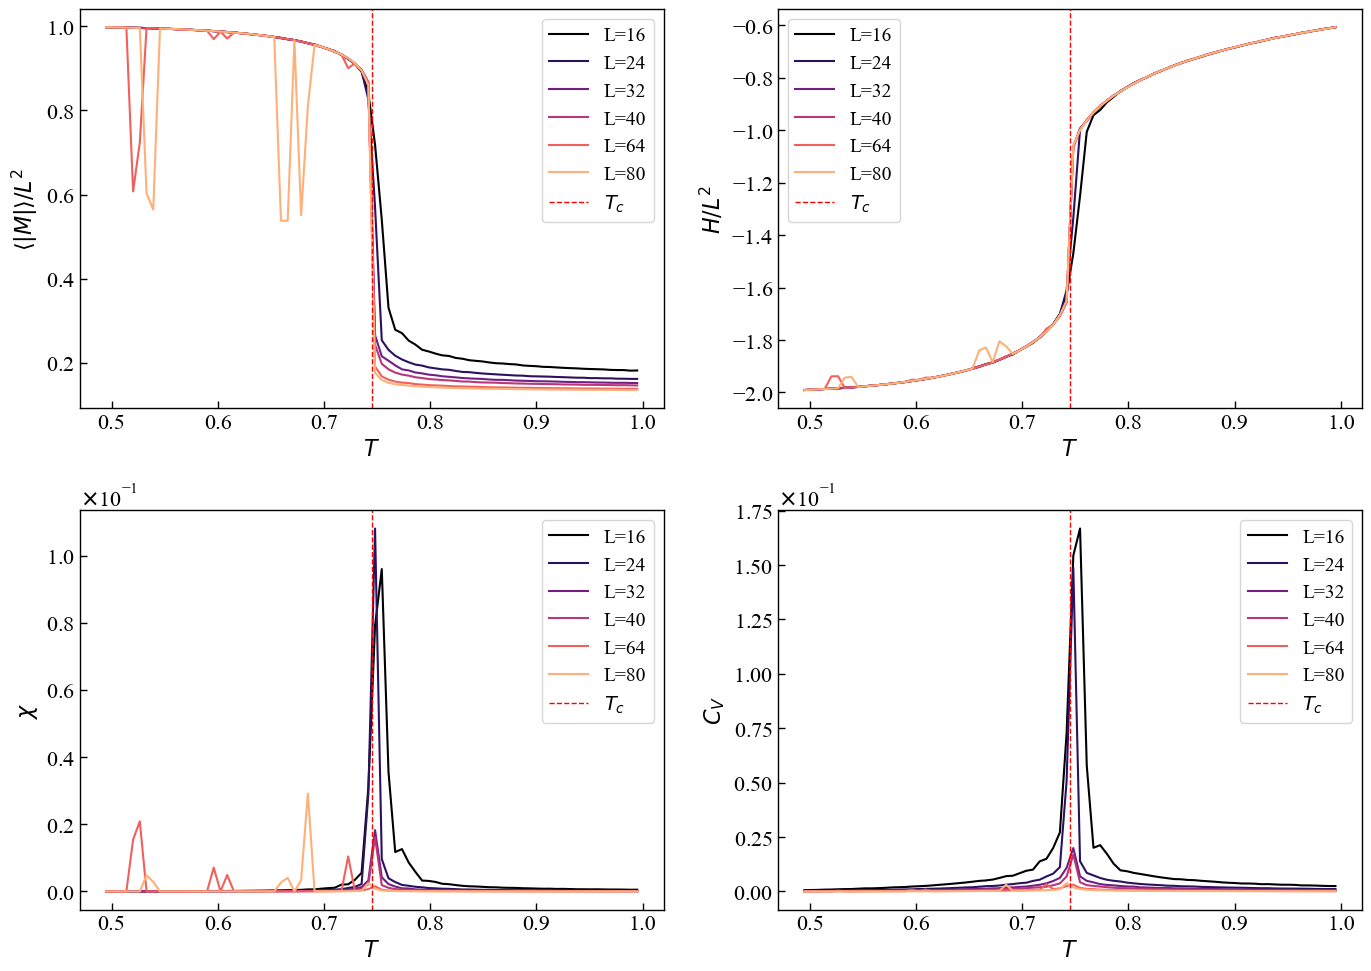

In [84]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Define your variables


# Line styles and markers
linestyles = ['-', '-', '-', '-']
markers = ['o', 's', '^', 'D', 'p', '*', 'x']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Plotting results for different observables
for i, L in enumerate(L_values):
    color = plt.cm.magma(i / len(L_values))  # Using a colormap to ensure different colors
    axs[0].plot(results[L]['T'], results[L]['mag_density'], linewidth=1.5, linestyle='-', color=color, label=f'L={L}')
    axs[1].plot(results[L]['T'], results[L]['energy_density'], linestyle='-', color=color, label=f'L={L}')
    axs[2].plot(results[L]['T'], results[L]['susceptibility'], linestyle='-', color=color,  label=f'L={L}')
    axs[3].plot(results[L]['T'], results[L]['specific_heat'], linestyle='-', color=color, label=f'L={L}')

# Critical temperature line and labeling
for ax in axs:
    ax.axvline(x=Tc, color='r', linestyle='--', linewidth=1, label='$T_c$')

# Titles and labels
titles = ['Avg. Absolute Magnetization', 'Energy Density', 'Susceptibility', 'Specific Heat']
y_labels = [r'$\langle \vert M \vert \rangle /L^2$', '$H/L^2$', '$\chi$', '$C_V$']

for ax, title, y_label in zip(axs, titles, y_labels):
    ax.set_xlabel(r'$T$')
    ax.set_ylabel(y_label)
    #ax.set_xlim(T_range[0], T_range[-1])
    ax.legend()
    ax.tick_params(direction='in', length=5, width=1, which='both')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, 1))

# Adjust layout and show/save the figure
plt.tight_layout()
plt.show()
fig.savefig(f"pottsdata/pottsobservables_q{q}_L{L_values}_mcsmax{mcsmax}_no{no}_ndelta{n_delta}.png")


## finite size scaling

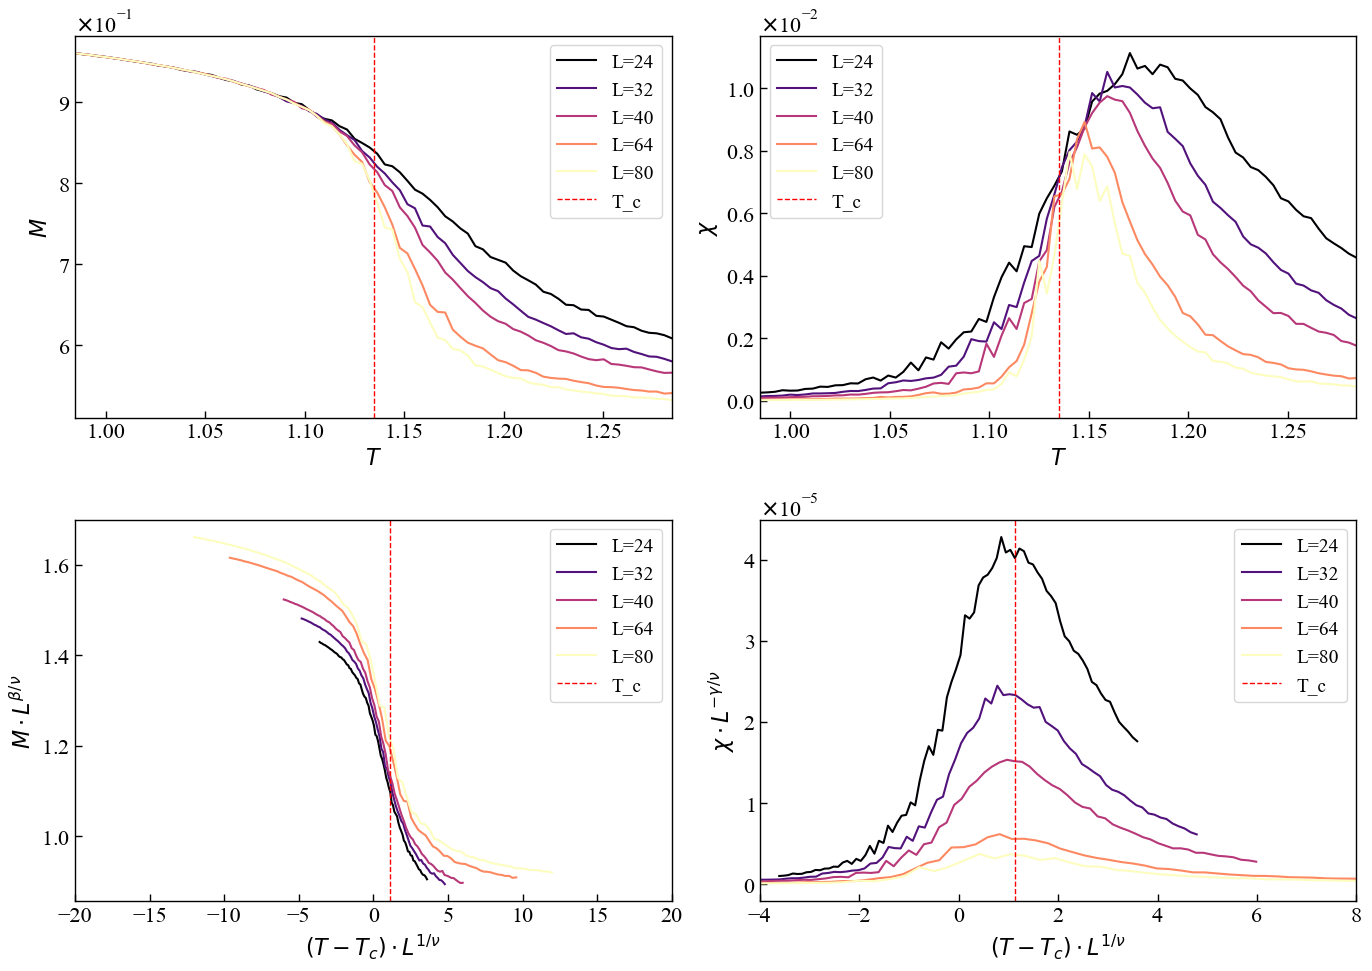

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Line styles and colors
linestyles = ['-', '--', '-.', ':', (0, (3, 5, 3, 5)), (0, (5, 1)), (0, (2, 5, 2, 5))]
colors = plt.cm.magma(np.linspace(0, 1, len(L_values)))
Tc = 1.135
def plot_magnetization_temp(ax, results, L_values, T_range):
    for i, L in enumerate(L_values):
        magnetizations = results[L]['mag_density']
        ax.plot(T_range, magnetizations, linestyle='-', color=colors[i], linewidth=1.5, label=f'L={L}')
    ax.axvline(x=Tc, color='r', linestyle='--', linewidth=1, label='T_c')
    ax.set_xlim(T_range[0], T_range[-1])
    ax.set_xlabel('$T$')
    ax.set_ylabel('$M$')
    ax.legend()
    ax.tick_params(direction='in', length=5, width=1, which='both')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, 1))

def plot_finite_size_scaling(ax, results, L_values, T_range, Tc, nu, beta):
    for i, L in enumerate(L_values):
        xs, ys = [], []
        for j, T in enumerate(T_range):
            mean_magnetization = results[L]['mag_density'][j]
            x = (T - Tc) * L**(1/nu)
            y = mean_magnetization * L**(beta/nu)
            xs.append(x)
            ys.append(y)
        ax.plot(xs, ys, linestyle='-', color=colors[i], label=f'L={L}')
    ax.axvline(x=Tc, color='r', linestyle='--', linewidth=1, label='T_c')
    ax.set_xlim(-20, 20)
    ax.set_xlabel('$(T - T_c) \cdot L^{1/\\nu}$')
    ax.set_ylabel('$M \cdot L^{\\beta/\\nu}$')
    ax.legend()
    ax.tick_params(direction='in', length=5, width=1, which='both')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, 1))

def plot_susceptibility_temp(ax, results, L_values, T_range):
    for i, L in enumerate(L_values):
        susceptibilities = results[L]['susceptibility']
        ax.plot(T_range, susceptibilities, linestyle='-', color=colors[i], linewidth=1.5, label=f'L={L}')
    ax.axvline(x=Tc, color='r', linestyle='--', linewidth=1, label='T_c')
    ax.set_xlim(T_range[0], T_range[-1])
    ax.set_xlabel('$T$')
    ax.set_ylabel('$\chi$')
    ax.legend()
    ax.tick_params(direction='in', length=5, width=1, which='both')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, 1))

def plot_finite_size_scaling_susceptibility(ax, results, L_values, T_range, Tc, gamma, nu):
    for i, L in enumerate(L_values):
        xs, ys = [], []
        for j, T in enumerate(T_range):
            susceptibility = results[L]['susceptibility'][j]
            x = (T - Tc) * L**(1/nu)
            y = susceptibility * L**(-gamma/nu)
            xs.append(x)
            ys.append(y)
        ax.plot(xs, ys, linestyle='-', color=colors[i], label=f'L={L}')
    ax.axvline(x=Tc, color='r', linestyle='--', linewidth=1, label='T_c')
    ax.set_xlim(-4, 8)
    ax.set_xlabel('$(T - T_c) \cdot L^{1/\\nu}$')
    ax.set_ylabel('$\chi \cdot L^{-\gamma/\\nu}$')
   
    #ax.set_title('Finite-Size Scaling Collapse for Susceptibility')
    ax.legend()
    ax.tick_params(direction='in', length=5, width=1, which='both')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, 1))


# Create subplots for plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
plot_magnetization_temp(ax1, results, L_values, T_range)
plot_susceptibility_temp(ax2, results, L_values, T_range)
plot_finite_size_scaling(ax3, results, L_values, T_range, Tc, nu, beta)
plot_finite_size_scaling_susceptibility(ax4, results, L_values, T_range, Tc, gamma, nu)

plt.tight_layout()
plt.show()
fig.savefig(f"pottsdata/pottsfinitesizescaling_qfinaaaaaaaalq2.png")#{q}_L{L_values}_mcsmax{mcsmax}_no{no}_ndelta{n_delta}.png")

In [74]:
#results[results['Lattice Size'] !=8]

print(results[16]['T'])


[1.059592657106511, 1.072092657106511, 1.084592657106511, 1.097092657106511, 1.109592657106511, 1.1220926571065108, 1.134592657106511, 1.147092657106511, 1.159592657106511, 1.172092657106511, 1.1845926571065108, 1.197092657106511, 1.209592657106511, 1.222092657106511, 1.234592657106511, 1.2470926571065108, 1.259592657106511, 1.272092657106511, 1.284592657106511]


array([1.05959266, 1.07209266, 1.08459266, 1.09709266, 1.10959266,
       1.12209266, 1.13459266, 1.14709266, 1.15959266, 1.17209266,
       1.18459266, 1.19709266, 1.20959266, 1.22209266, 1.23459266,
       1.24709266, 1.25959266, 1.27209266, 1.28459266])

Extrapolated critical temperature T_C: 1.1313 ± 0.0038
Fit parameter a: 0.9594 ± 0.1377


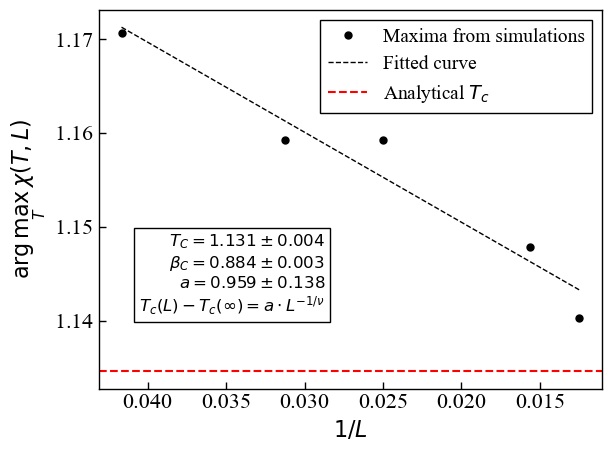

NameError: name 'mcsmax' is not defined

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Define the scaling function globally
def scaling_func(L, Tc, a, nu):
    return Tc + a * L**(-1/nu)

def find_susceptibility_maxima(results, L_values, T_range, precision=4):
    maxima = {}
    for L in L_values:
        susceptibilities = results[L]['susceptibility']
        if susceptibilities:  # Ensure there are susceptibility values available
            max_index = np.argmax(susceptibilities)  # Index of maximum susceptibility
            max_temperature = T_range[max_index]  # Corresponding temperature
            max_susceptibility = susceptibilities[max_index]  # Maximum susceptibility value
            maxima[L] = (max_temperature, max_susceptibility)
        else:
            print(f"No susceptibility data available for L = {L}")
    return maxima


def extrapolate_critical_temperature(maxima, L_values, nu):
    # Prepare data for fitting
    Ls = np.array(L_values, dtype=float)
    T_peaks = np.array([maxima[L][0] for L in L_values], dtype=float)
    
    # Perform the curve fitting
    popt, pcov = opt.curve_fit(lambda L, Tc, a: scaling_func(L, Tc, a, nu), Ls, T_peaks)
    Tc_extrapolated, a = popt
    # Error estimates from the square root of the diagonals of the covariance matrix
    errors = np.sqrt(np.diag(pcov))
    
    return Tc_extrapolated, a, errors


# Simulation parameters
precision = 4
nu = 1.0  # Example value for the critical exponent nu
#T_range = T_range[T_range > 1.05]
# Assuming results, L_values, and T_range are predefined and loaded with data
maxima = find_susceptibility_maxima(results, L_values, T_range, precision)
Tc_extrapolated, fit_param_a, errors = extrapolate_critical_temperature(maxima, L_values, nu)
Tc_error, a_error = errors

# Calculate the critical inverse temperature and its error
beta_c = 1 / Tc_extrapolated
beta_c_error = Tc_error / (Tc_extrapolated ** 2)

# Output results with error
print(f"Extrapolated critical temperature T_C: {Tc_extrapolated:.4f} ± {Tc_error:.4f}")
print(f"Fit parameter a: {fit_param_a:.4f} ± {a_error:.4f}")

# Plotting
# Plotting
fig, ax = plt.subplots()
ax.plot(1/np.array(L_values), [maxima[L][0] for L in L_values], 'ko', label='Maxima from simulations')
ax.plot(1/np.array(L_values), [scaling_func(L, Tc_extrapolated, fit_param_a, nu) for L in L_values], '--k',linewidth=1, label='Fitted curve')
ax.set_xlabel('$1/L$')
ax.set_ylabel(r'$\arg \max_{T}\, \chi(T,L)$')

# Add a textbox with Tc, fit parameter, and the fit formula
textstr = (r'$T_C = {:.3f} \pm {:.3f}$' '\n' 
           r'$\beta_C = {:.3f} \pm {:.3f}$' '\n'
           r'$a = {:.3f} \pm {:.3f}$' '\n' 
           r'$T_c(L)-T_c(\infty) = a \cdot L^{{-1/\nu}}$' .format(Tc_extrapolated, Tc_error, beta_c, beta_c_error, fit_param_a, a_error, nu)
          )
props = dict(boxstyle='square', facecolor='white', alpha=1.0)

# Place a text box in the right middle of the axes coords
ax.text(0.45, 0.3, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='center', horizontalalignment='right', bbox=props)

beta_c_analytical = 1/(0.4407*2)  # Tc instead of beta_c
ax.axhline(y=Tc, color='r', linestyle='--', label=f'Analytical $T_c$')

ax.set_xlim(ax.get_xlim()[::-1])
ax.tick_params(direction='in', length=5, width=1, which='both')
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, 1))
ax.legend(fancybox=False,framealpha=1,edgecolor='k')
plt.tight_layout()
plt.show()
fig.savefig(f"pottsdata/pottsextractTc_q{q}_L{L_values}_mcsmax{mcsmax}_no{no}_ndelta{n_delta}.png")

# Binder cumulant

In [11]:
import pandas as pd

# Load the dataset
data_path = 'pottsdata/pottsdata_q2_L[8, 16, 32, 64]_mcsmax10000_no1000_ndelta50.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,Unnamed: 0,Lattice Size,Beta,Magnetization Density,Energy Density,Susceptibility,Specific Heat,Binder Cumulant
0,0,8,0.850000,0.850128,-1.694196,0.013812,0.021178,0.729414
1,1,8,0.852083,0.863202,-1.701052,0.010368,0.018363,0.729350
2,2,8,0.854167,0.868702,-1.710778,0.010232,0.017570,0.726955
3,3,8,0.856250,0.860013,-1.699458,0.012263,0.019026,0.727627
4,4,8,0.858333,0.863441,-1.702647,0.011112,0.019613,0.728092


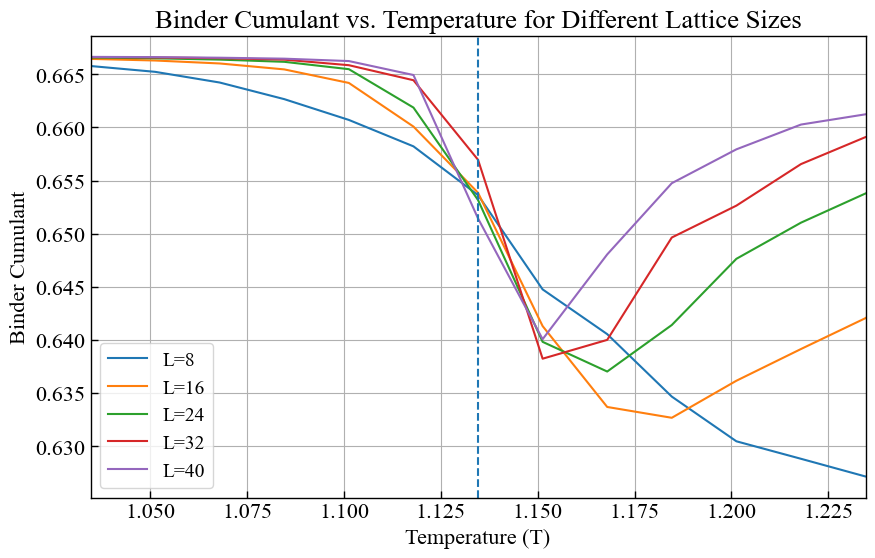

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
for L in L_values:
    ax.plot(T_range, results[L]['binder_cumulant'], label=f'L={L}')
ax.set_xlabel('Temperature (T)')
ax.set_ylabel('Binder Cumulant')
ax.set_title('Binder Cumulant vs. Temperature for Different Lattice Sizes')
ax.axvline(Tc,linestyle='--')
ax.set_xlim(Tc-0.1,Tc+0.1)
ax.legend()
plt.grid(True)
plt.show()


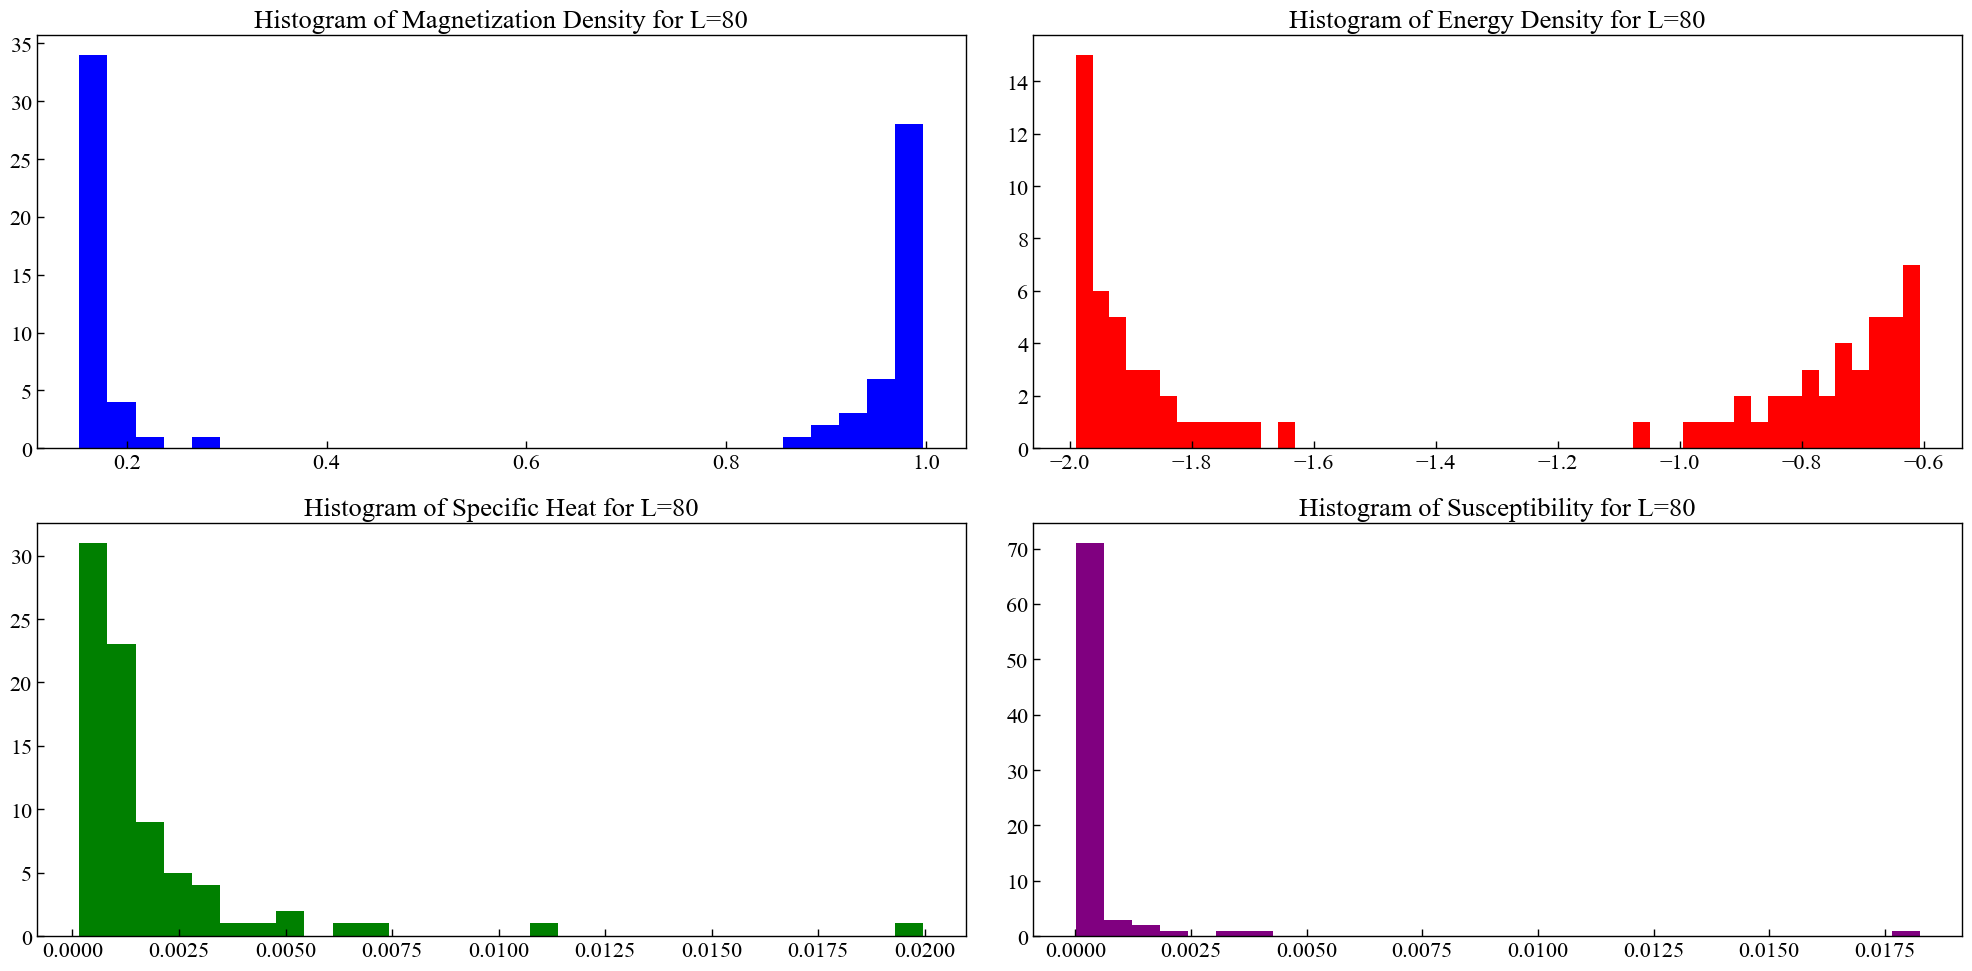

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('pottsdata/pottsdata_q8_T_L[16, 24, 32, 40, 64, 80]_mcsmax80000_no30000_ndelta10_Trange80.csv')

# Filter the data for L=80
filtered_data = data[data['Lattice Size'] == 32]

# Create histograms for each required metric
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.hist(filtered_data['Magnetization Density'], bins=30, color='blue')
plt.title('Histogram of Magnetization Density for L=80')

plt.subplot(2, 2, 2)
plt.hist((np.array(filtered_data['Energy Density'])), bins=50, color='red')
plt.title('Histogram of Energy Density for L=80')

plt.subplot(2, 2, 3)
plt.hist(filtered_data['Specific Heat'], bins=30, color='green')
plt.title('Histogram of Specific Heat for L=80')

plt.subplot(2, 2, 4)
plt.hist(filtered_data['Susceptibility'], bins=30, color='purple')
plt.title('Histogram of Susceptibility for L=80')

plt.tight_layout()
plt.show()


### Calculate beta_c with bootstrap

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import sem

data = pd.read_csv('pottsdata/pottsdata_q2_L[8, 16]_mcsmax5000_no1000_ndelta100.csv')
# Group by 'Inverse Temperature Beta' and calculate means and SEM (standard error of the mean)
grouped_data = data.groupby('Inverse Temperature Beta').agg(['mean', sem])

# Now let's perform the bootstrap separately for susceptibility and specific heat
n_bootstraps = 1000
bootstrap_estimates_susceptibility = []
bootstrap_estimates_specific_heat = []

for _ in range(n_bootstraps):
    # Create a bootstrap sample for susceptibility and specific heat separately
    bootstrap_susceptibility = grouped_data['Susceptibility'].sample(frac=1, replace=True).reset_index()
    bootstrap_specific_heat = grouped_data['Specific Heat'].sample(frac=1, replace=True).reset_index()

    # Find the index of the maximum value (peak) in the bootstrap samples
    max_susceptibility_index = bootstrap_susceptibility['mean'].idxmax()
    max_specific_heat_index = bootstrap_specific_heat['mean'].idxmax()

    # Get the corresponding beta values for the peaks
    beta_susceptibility_peak = bootstrap_susceptibility['Inverse Temperature Beta'][max_susceptibility_index]
    beta_specific_heat_peak = bootstrap_specific_heat['Inverse Temperature Beta'][max_specific_heat_index]

    # Add to the list of bootstrap estimates
    bootstrap_estimates_susceptibility.append(beta_susceptibility_peak)
    bootstrap_estimates_specific_heat.append(beta_specific_heat_peak)

# Calculate the standard deviation of the bootstrap estimates as the error for susceptibility and specific heat
bootstrap_error_susceptibility = np.std(bootstrap_estimates_susceptibility)
bootstrap_error_specific_heat = np.std(bootstrap_estimates_specific_heat)
mean_beta_c_susceptibility = np.mean(bootstrap_estimates_susceptibility)
mean_beta_c_specific_heat = np.mean(bootstrap_estimates_specific_heat)

# Print the estimated beta_c and its error separately for susceptibility and specific heat
beta_c_with_error_susceptibility = f"{mean_beta_c_susceptibility:.4f} ± {bootstrap_error_susceptibility:.4f}"
beta_c_with_error_specific_heat = f"{mean_beta_c_specific_heat:.4f} ± {bootstrap_error_specific_heat:.4f}"

print(f"Estimated beta_c from susceptibility peak: {beta_c_with_error_susceptibility}")
print(f"Estimated beta_c from specific heat peak: {beta_c_with_error_specific_heat}")


Estimated beta_c from susceptibility peak: 0.8049 ± 0.0485
Estimated beta_c from specific heat peak: 0.8541 ± 0.0486


In [21]:
from scipy.stats import sem
import numpy as np

# Assuming 'data' is your DataFrame and it contains multiple measurements
# for each beta value, you could group by beta and calculate mean and SEM for susceptibility and specific heat.

data = pd.read_csv('pottsdata/pottsdata_q2_L[8, 16]_mcsmax5000_no1000_ndelta100.csv')
# Group by 'Inverse Temperature Beta' and calculate means and standard error of the mean (SEM)
grouped_data = data.groupby('Inverse Temperature Beta').agg(['mean', sem])

# Now let's perform the bootstrap
n_bootstraps = 1000
bootstrap_estimates = []

for _ in range(n_bootstraps):
    # Create a bootstrap sample for each property
    bootstrap_susceptibility = grouped_data['Susceptibility'].sample(frac=1, replace=True).reset_index()
    bootstrap_specific_heat = grouped_data['Specific Heat'].sample(frac=1, replace=True).reset_index()

    # Find the index of the maximum value (peak) in the bootstrap samples
    max_susceptibility_index = bootstrap_susceptibility['mean'].idxmax()
    max_specific_heat_index = bootstrap_specific_heat['mean'].idxmax()

    # Get the corresponding beta values for the peaks
    beta_susceptibility_peak = bootstrap_susceptibility['Inverse Temperature Beta'][max_susceptibility_index]
    beta_specific_heat_peak = bootstrap_specific_heat['Inverse Temperature Beta'][max_specific_heat_index]

    # Average to estimate beta_c and add to the list of bootstrap estimates
    bootstrap_estimates.append(np.mean([beta_susceptibility_peak, beta_specific_heat_peak]))

# Calculate the standard deviation of the bootstrap estimates as the error
bootstrap_error = np.std(bootstrap_estimates)
mean_beta_c = np.mean(bootstrap_estimates)

# Print the estimated beta_c and its error
beta_c_with_error = f"{mean_beta_c} ± {bootstrap_error}"
print(f"Estimated beta_c: {beta_c_with_error}")
print(f"estimated beta_c interval: {mean_beta_c-bootstrap_error} - {mean_beta_c+bootstrap_error}")

Estimated beta_c: 0.8300333333333335 ± 0.03433817118018954
estimated beta_c interval: 0.795695162153144 - 0.8643715045135231
